# Tutorial on utilizing Keras to perform Semantic Segmentation on Fire damage data

#### What is Semantic Segmentation?

* Semantic segmentation is a computer vision task that involves assigning a class label to each pixel in an image, thereby dividing the image into various meaningful regions or objects.
* One of the main ways semantic segmentation is done is with a UNET style of CNN architecture.
    - The architecture of UNet consists of an encoder-decoder framework with skip connections. The encoder part is designed to capture context and extract features from the input image, gradually reducing spatial dimensions. It typically consists of convolutional and pooling layers, which help to downsample the image while increasing the number of channels.
    - The decoder part, on the other hand, aims to recover the spatial information and generate a segmentation map. It consists of upsampled feature maps that are gradually concatenated with the corresponding feature maps from the encoder side. This process allows the model to make use of both low-level and high-level features to produce accurate segmentations. The decoder often includes convolutional and upsampling layers.
    - The skip connections in UNet play a crucial role in retaining the spatial information. They connect the feature maps from the encoder to the corresponding layers in the decoder, enabling precise localization of objects. These skip connections help to overcome the problem of information loss during the downsampling process and improve the overall segmentation performance.

#### Steps to perform segmentation
This tutorial is going to be broken down into a number of steps. Each step we will be preforming a necessary task in order to segment our fire damage data. These steps are as follows:  

0. Generating image chips and label chips with ARCGIS
1. Importing in libraries
2. Reading in the Data
3. Data preprocessing
4. Data Visualization
5. Splitting into training and testing data
6. Creating our callbacks and class weighting
7. Training our models
    1. Preprocess data for each model
    2. Each model will go through hyperparameter optimization
    3. Train and save the optimized model
8. Result visualization
9. Preform any batching to improve results
10. Export prediction chips with geo-reference data and display on ARCGIS

**Importing the Necessary Libraries**

In [2]:
## Need to do Pocket Nuns still
%load_ext autoreload
%autoreload 2
import helper_functions as hp
import numpy as np
import pandas as pd
import keras_tuner
import gc
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import mobilenet_v2 , resnet50
from sklearn.utils import class_weight

## 4 1 2 bands for near infrared
## 1 2 3 for normal rgb

2023-05-24 11:00:09.288147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 11:00:09.433040: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Uncomment the code below to check that your tensorflow is using
## available GPU's

# import tensorflow as tf
# tf.version.VERSION
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# ##device_lib.list_local_devices()

Num GPUs Available:  2


# Generating Chips in ARCGis

# **Loading in Data** - Functions to load in data and preprocessor

The first thing we need to do is read in the different fire images and corresponding labels.
The function segmented_dataset_reader will handle this. In order to do this pass in the foldername of the fire data you want to read in and whether you are reading in that data as a training or testing set.
The expected structure of this folder is a folder containing two folders. One named images and another named labels. It expects both the images and labels to be stored as tifs.

This will output the dataset into two or three numpy arrays. The amount depends on if the train_bool flag was set to true or false. that will contain the images in one array, then the geo-reference data in another array and then finally the labels in a final array.  
Additional information about the segemented_dataset_reader function is provided as documentation in the helper_functions file.

Quick tip if a factor int parameter is passed into the segmented_dataset_reader function then only a portion of the entire dataset will be read in. This is useful for testing on smaller datasets in order to speed up computation.  
i.e hp.segmented_dataset_reader('foldername', factor = 10) >>> this will only read in 1/10 of the data

In [3]:
Pocket_images,Pocket_geo,Pocket_labels = hp.segmented_dataset_reader('PocketN_6_64', factor = 1)
Nuns_images,Nuns_geo, Nuns_labels = hp.segmented_dataset_reader('NunsN_6_64', train_bool=False, factor = 1)
Tubbs_images,Tubbs_geo, Tubbs_labels = hp.segmented_dataset_reader('tubbsN_6_64', train_bool=False, factor = 1)

reading in 7189 images
reading in 13663 images
reading in 10142 images


In [3]:
## This cell is used to verify that the images and labels were read in correctly
## images should be a 4D array of shape (numfiles, height, width, channels)
## labels should be a 3D array of shape (numfiles, height, width)
## datatype for images should be float 32 
## datatype for labels should be uint8
print(Pocket_images.shape, Pocket_labels.shape)
print(Nuns_images.shape, Nuns_labels.shape)
print(Tubbs_images.shape, Tubbs_labels.shape)

assert Pocket_images.ndim == 4
assert Nuns_images.ndim == 4
assert Tubbs_images.ndim == 4

assert Pocket_labels.ndim == 3
assert Nuns_labels.ndim == 3
assert Tubbs_labels.ndim == 3

assert Pocket_images.dtype == 'float32'
assert Nuns_images.dtype == 'float32'
assert Tubbs_images.dtype == 'float32'

assert Pocket_labels.dtype == 'uint8'
assert Nuns_labels.dtype == 'uint8'
assert Tubbs_labels.dtype == 'uint8'


(7189, 128, 128, 3) (7189, 128, 128)
(13663, 128, 128, 3) (13663, 128, 128)
(10142, 128, 128, 3) (10142, 128, 128)


# **Data Preprocessing:**

Now that the images and labels are read in correctly we need to do a bit of preprocessing before we feed then into our networks

* we need to make sure the labels only contain values from 0 - 5:
    This will be checked with np.unique. Since the labels from the original data are 1 - 6 for fire damage and 0 for background we need to subtract 1 from all values greater then 0. Since the data was created to only have a few pixels of background, setting 5% fire damage and background as the same shouldn't cause an issue down the line in our networks

In [4]:
## checking to see if our labels have a valid range ie (1-6) 
## maybe including 0 depending on how much of the dataset is read in
print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

expected_labels = np.array([1, 2, 3, 4, 5, 6])
assert np.all(np.in1d(expected_labels, np.unique(Pocket_labels)))
assert np.all(np.in1d(expected_labels, np.unique(Nuns_labels)))
assert np.all(np.in1d(expected_labels, np.unique(Tubbs_labels)))

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      39, 26752177, 24112194, 17624199, 11158479,  8881664,
       29255824]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([       31,  15240345,  26102818,  24247211,  18907182,  17616009,
       121740996]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      43, 16721652, 25556290, 16293345, 11829351, 12645205,
       83120642]))


In [4]:
## will subtract 1 from all labels greater then 0 in order to change the range of our data
## from 1 - 6 to 0 - 5 
## ONLY RUN THIS CELL ONCE
Pocket_labels = np.where(Pocket_labels != 0, Pocket_labels - 1, Pocket_labels)
Nuns_labels = np.where(Nuns_labels != 0, Nuns_labels - 1, Nuns_labels)
Tubbs_labels = np.where(Tubbs_labels != 0, Tubbs_labels - 1, Tubbs_labels)

In [6]:
## labels should now be in the range 0 - 5

print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

expected_labels = np.array([0, 1, 2, 3, 4, 5])
assert np.array_equal(np.unique(Pocket_labels), expected_labels)
assert np.array_equal(np.unique(Nuns_labels),expected_labels)
assert np.array_equal(np.unique(Tubbs_labels),expected_labels)

(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([26752216, 24112194, 17624199, 11158479,  8881664, 29255824]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 15240376,  26102818,  24247211,  18907182,  17616009, 121740996]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([16721695, 25556290, 16293345, 11829351, 12645205, 83120642]))


# **Displaying images and labels**

This is just used to display a few random images in order once again make sure our data was read in correctly.  
Just change the values in the array to display different images.  
Changing from Pocket_images to Nuns_image or Tubbs_images will display data from the other fire datasets.  
Same is true for the labels.

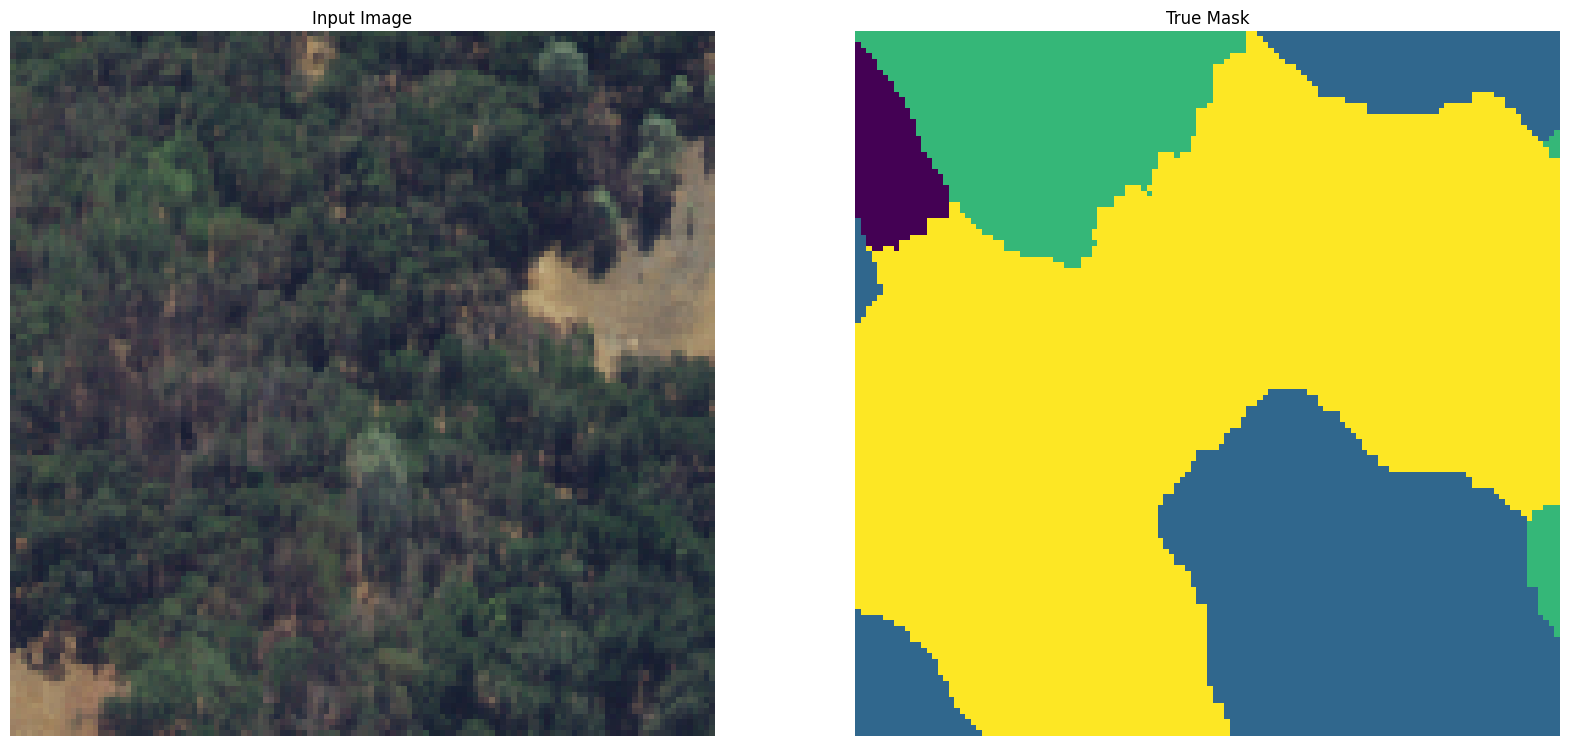

In [7]:
img = Pocket_images[400]/255.0 # divide by 255 since images are float but with range 0-255 right now
lbl = Pocket_labels[400]
hp.display([img,lbl])


# **Creating training and testing datasets**


Now will be be separating our data out into training and testing datasets. We are using a leave one out method of training our networks. These means we are going to train out network on two fires and test on the third.
In order to do this we will concatenate the arrays of two fires together and then designate the other fire as the test fire.



In [4]:
train_images = np.concatenate((Pocket_images,Tubbs_images ), axis=0)
train_labels = np.concatenate((Pocket_labels,Tubbs_labels ), axis=0)
test_images = Nuns_images
test_labels = Nuns_labels

In [6]:
# uncomment this cells if you are having memory space issues. 
# This will dereference these variable names and could help free up some memory

# del Pocket_images
# del Pocket_labels
# del Nuns_images
# del Nuns_labels
# del Tubbs_images
# del Tubbs_labels

In [9]:
print(train_images.shape, train_labels.shape)
print(train_images.dtype, train_labels.dtype)
print(train_images.max(),train_images.min())
print(np.unique(train_labels, return_counts=True))
print(test_images.shape, test_labels.shape)
print(test_images.dtype, test_labels.dtype)

(17331, 128, 128, 3) (17331, 128, 128)
float32 uint8
229.0 4.0
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 43473911,  49668484,  33917544,  22987830,  21526869, 112376466]))
(13663, 128, 128, 3) (13663, 128, 128)
float32 uint8


# **Class weights and callbacks**

Now that we have created our training and testing dataset we can move on to setting up some parameters for our networks

* First we are generating our class weights - These will given to our loss function in order to help correct for any class imbalance issues in our dataset
    - You might have noticed early when we call np.unique that our dataset is not that even distributed among all the classes
    - This can cause issues with our training so providing the class weights to our loss function can account for this

* Next we are setting up our callbacks for the network - These callbacks are reduce_lr and early_stopping
    - These callbacks are useful because they reduce training time and overfitting


In [5]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(train_labels.flatten()), y = train_labels.flatten())
print(class_weights)

[1.09952373 0.94390585 1.37928619 1.99127654 2.15358965 0.42743382]


In [6]:
#All my callback are called here
r_lr = hp.reduce_lr()
e_stop = hp.early_stop()
_callbacks = [r_lr, e_stop]
gc.collect()

0

# **Hyper parameter optimization for the simple UNET** 
- Hyperparameter optimzation using keras tuner
    - Keras Tuner is a hyperparameter tuning library for Keras. It is designed to help automate the process of finding the optimal set of hyperparameters for a given deep learning model. 
    - Hyperparameters are the configuration choices made before training a model, such as the learning rate, batch size, number of layers, and activation functions.
- Using Random Search but a more efficient algorithm can be chosen such as Bayesian optimization
- A tip when doing hyperparameter tuning is to read only a four of the dataset since working with the entire dataset can take a really long time

In [22]:
#simple unet keras tuner builder
def build_Unet(hpf):
        _act = hpf.Choice("act",['elu','relu','sigmoid'])
        _act2 = hpf.Choice("act2",['elu','relu','sigmoid'])
        _drop_rate = hpf.Choice("drop_rate",[0.1,0.3,0.4])
        _drop_rate2 = hpf.Choice("drop_rate2",[0.1,0.2,0.3,0.4])
        _drop_bool = hpf.Boolean("drop_bool")
        _drop_bool2 = hpf.Boolean("drop_bool2")
        _filter = hpf.Choice("filter", [8,16,32,48])
        _lr = hpf.Float("lr", min_value=0.001, max_value=0.01, sampling="linear")
        _gamma = hpf.Choice("gamma", [1,2,3])
        model = hp.build_unet_model(6,act=_act, drop=_drop_rate, drop2=_drop_rate2,
                                drop_bool=_drop_bool, drop_bool2=_drop_bool2,
                                filter=_filter, act2=_act2, gamma=_gamma, lr=_lr)
        return model


In [ ]:
#keras_tuner hyperband object
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Unet,
    objective= _meaniou,
    max_trials = 30,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=True,
)

In [ ]:
#performs hyper parameter optimization
tuner.search(
    train_images/255.0,
    train_labels,
    validation_data=(test_images/255.0, test_labels),
    batch_size = 32,
    epochs = 4,
)

In [ ]:
## this will display the results of the training
tuner.results_summary()

In [ ]:
## this will create a dataframe of the top ten combinations of parameters and display then
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)
    df = pd.DataFrame(mylist)
print(df)

# **optimized simple unet fitting**
Now using the optimized parameters found from using keras tuner we can fit the optimized model.  
If we are happy with the results we can save the trained model.  
There are also a few functions we call to display our curves for loss, meaniuo and accuracy

In [28]:
model = hp.build_unet_model(num_class = 6, weights = class_weights)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 48  219        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 128, 128, 48  2784       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

In [29]:
gc.collect()

1456

In [30]:
## noticed that the training and testing images are getting preprocessed before being fed into the model
history = model.fit(train_images/255.0, train_labels, epochs=50, validation_data=(test_images/255.0, test_labels), batch_size=16, callbacks = _callbacks, shuffle=True)  #beat 0.3770 #beat 0.3314

Epoch 1/2
1084/1084 [==============================] - 121s 107ms/step - loss: 1.0971 - accuracy: 0.4778 - mean_io_u: 0.2554 - val_loss: 1.8872 - val_accuracy: 0.2126 - val_mean_io_u: 0.1192 - lr: 0.0030
Epoch 2/2
1084/1084 [==============================] - 115s 106ms/step - loss: 0.9645 - accuracy: 0.5230 - mean_io_u: 0.3001 - val_loss: 2.4053 - val_accuracy: 0.1839 - val_mean_io_u: 0.0818 - lr: 0.0030


In [17]:
## This is used to save the currently trained model
## MAKE SURE TO REPLACE THE FIRE NAMES WITH THE NAME OF THE FIRES USED IN THE TRAINING DATA
## IE PocketNuns if the training data is Pocket and Nuns
## or PocketTubbs if the training data is Pocket and Tubbs

# model.save('Models/simple_seg_model_full_6class_PocketNuns.tf', overwrite=True)

INFO:tensorflow:Assets written to: Models/simple_seg_model_full_6class_PocketNuns.tf/assets


INFO:tensorflow:Assets written to: Models/simple_seg_model_full_6class_PocketNuns.tf/assets


In [ ]:
hp.plot_accuracy(history)
hp.plot_loss(history)
hp.plot_meaniou(history)

In [ ]:
hp.show_predictions(model, test_images[100:105], test_labels[100:105], 5, "Simple U-Net")
#del model

# **Hyper Parameter optimization of MobileUnet** 
- Hyperparameter optimzation using keras tuner
    - Keras Tuner is a hyperparameter tuning library for Keras. It is designed to help automate the process of finding the optimal set of hyperparameters for a given deep learning model. 
    - Hyperparameters are the configuration choices made before training a model, such as the learning rate, batch size, number of layers, and activation functions.
- Using Random Search but a more efficient algorithm can be chosen such as Bayesian optimization
- A tip when doing hyperparameter tuning is to read only a four of the dataset since working with the entire dataset can take a really long time


In [31]:
def build_Mobile_Unet(hpf):
        _trainable = hpf.Choice("trainable", [1,2,3,4,5,6,7])
        _batch_bool = hpf.Boolean("batch_bool")
        _lr = hpf.Float("lr", min_value=0.001, max_value=0.01, sampling="linear")
        _gamma = hpf.Choice("gamma", [1,2,3])
        model = hp.mobile_unet_model(6, trainable = _trainable, batch_bool = _batch_bool, lr = _lr, gamma = _gamma)
        return model

In [33]:
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Mobile_Unet,
    objective= _meaniou,
    max_trials = 30,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=True,
)

In [ ]:
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

In [25]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)

[{'training layers': 2, 'lr': 0.00454075841255362}, {'training layers': 2, 'lr': 0.005490222637767316}, {'training layers': 2, 'lr': 0.004242922659531865}, {'training layers': 2, 'lr': 0.005773107053690844}, {'training layers': 2, 'lr': 0.0031312733259334018}, {'training layers': 5, 'lr': 0.0034807827859902126}, {'training layers': 2, 'lr': 0.005706033148428903}, {'training layers': 3, 'lr': 0.005498696508094774}, {'training layers': 2, 'lr': 0.0035225490910381625}, {'training layers': 3, 'lr': 0.0038647162039910287}]


In [26]:
df = pd.DataFrame(mylist)
df

,training layers,lr
0,2,0.004541
1,2,0.005490
2,2,0.004243
3,2,0.005773
4,2,0.003131
5,5,0.003481
6,2,0.005706
7,3,0.005499
8,2,0.003523
9,3,0.003865


# **Fitting the optimized mobile Unet**
Now using the optimized parameters found from using keras tuner we can fit the optimized model.  
If we are happy with the results we can save the trained model.  
There are also a few functions we call to display our curves for loss, meaniuo and accuracy

In [46]:
keras.backend.clear_session()
model_mobile = hp.mobile_unet_model(output_channels=6, weights=class_weights)
model_mobile.summary()
gc.collect()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_1[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

42644

In [47]:
gc.collect()


0

In [48]:
## noticed that the training and testing images are getting preprocessed before being fed into the model
history_mobile = model_mobile.fit(mobilenet_v2.preprocess_input(np.copy(train_images)), train_labels, epochs=1, batch_size=16,
                                  validation_data=(mobilenet_v2.preprocess_input(np.copy(test_images)), test_labels),
                                  callbacks=_callbacks, shuffle=True)  #.3175

In [65]:
## This is used to save the currently trained model
## MAKE SURE TO REPLACE THE FIRE NAMES WITH THE NAME OF THE FIRES USED IN THE TRAINING DATA
## IE PocketNuns if the training data is Pocket and Nuns
## or PocketTubbs if the training data is Pocket and Tubbs

#model_mobile.save('Models/mobilenet_seg_model_full_6class_PocketNuns.tf', overwrite=True)

In [ ]:
hp.plot_accuracy(history_mobile)
hp.plot_loss(history_mobile)
hp.plot_meaniou(history_mobile)

In [ ]:
hp.show_predictions(model_mobile, test_images[100:105], test_labels[100:105], 5, "MobileNet")

# **Hyper Parameter tuning for Deeplab**
- Hyperparameter optimzation using keras tuner
    - Keras Tuner is a hyperparameter tuning library for Keras. It is designed to help automate the process of finding the optimal set of hyperparameters for a given deep learning model. 
    - Hyperparameters are the configuration choices made before training a model, such as the learning rate, batch size, number of layers, and activation functions.
- Using Random Search but a more efficient algorithm can be chosen such as Bayesian optimization
- A tip when doing hyperparameter tuning is to read only a four of the dataset since working with the entire dataset can take a really long time


In [9]:
def build_Deeplab_Unet(hpf):
        _drop_rate = hpf.Choice("drop_rate",[0.1,0.3,0.4])
        _drop_rate2 = hpf.Choice("drop_rate2",[0.1,0.2,0.3,0.4])
        _batch_bool = hpf.Boolean("batch_bool")
        _batch_bool2 = hpf.Boolean("batch_bool2")
        _lr = hpf.Float("lr", min_value=0.004, max_value=0.005, sampling="linear")
        _gamma = hpf.Choice("gamma", [1,2,3])
        model = hp.DeeplabV3Plus(image_size=128, num_classes=6,drop_rate= _drop_rate, drop_rate2=_drop_rate2,
                                 batch_bool= _batch_bool, batch_bool2 = _batch_bool2, lr = _lr, gamma = _gamma)
        return model

In [11]:
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Deeplab_Unet,
    objective= _meaniou,
    max_trials = 20,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=False,
)

2023-05-23 21:34:19.420022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 21:34:20.194183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-23 21:34:20.194843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9444 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [11]:
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

Trial 20 Complete [00h 03m 16s]
val_mean_io_u: 0.3205831050872803

Best val_mean_io_u So Far: 0.3342233896255493
Total elapsed time: 00h 19m 40s
INFO:tensorflow:Oracle triggered exit


In [11]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)

[{'drop_rate': 0.4, 'drop_rate2': 0.2, 'batch_bool': True, 'batch_bool2': True, 'lr': 0.005367958117152761, 'gamma': 1}, {'drop_rate': 0.1, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.005782724486729771, 'gamma': 1}, {'drop_rate': 0.3, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.0050594386264619035, 'gamma': 3}, {'drop_rate': 0.3, 'drop_rate2': 0.1, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.003941540676815267, 'gamma': 2}, {'drop_rate': 0.4, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.003172746237806152, 'gamma': 2}, {'drop_rate': 0.3, 'drop_rate2': 0.4, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.003853109074008468, 'gamma': 3}, {'drop_rate': 0.4, 'drop_rate2': 0.3, 'batch_bool': True, 'batch_bool2': False, 'lr': 0.0033518332121181783, 'gamma': 2}, {'drop_rate': 0.3, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.004864675432932375, 'gamma': 3}, {'drop_rate': 0.1, 'drop_ra

In [12]:
df = pd.DataFrame(mylist)
df

,drop_rate,drop_rate2,batch_bool,batch_bool2,lr,gamma
0,0.4,0.2,True,True,0.005368,1
1,0.1,0.3,False,False,0.005783,1
2,0.3,0.3,False,False,0.005059,3
3,0.3,0.1,False,False,0.003942,2
4,0.4,0.3,False,True,0.003173,2
5,0.3,0.4,False,True,0.003853,3
6,0.4,0.3,True,False,0.003352,2
7,0.3,0.3,False,True,0.004865,3
8,0.1,0.3,False,False,0.003530,2
9,0.1,0.4,False,True,0.004225,2


# **Fitting optimized Deeplab model**
Now using the optimized parameters found from using keras tuner we can fit the optimized model.  
If we are happy with the results we can save the trained model.  
There are also a few functions we call to display our curves for loss, meaniuo and accuracy

In [12]:
keras.backend.clear_session()
model_deeplab = hp.DeeplabV3Plus(image_size=128, num_classes=6, weight=class_weights)
model_deeplab.summary()
gc.collect()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

1004

In [ ]:
dlab_history = model_deeplab.fit(resnet50.preprocess_input(np.copy(train_images)), train_labels, epochs=50, batch_size=16,
                                 validation_data=(resnet50.preprocess_input(np.copy(test_images)), test_labels),
                                 callbacks=_callbacks, shuffle=True)

In [ ]:
## This is used to save the currently trained model
## MAKE SURE TO REPLACE THE FIRE NAMES WITH THE NAME OF THE FIRES USED IN THE TRAINING DATA
## IE PocketNuns if the training data is Pocket and Nuns
## or PocketTubbs if the training data is Pocket and Tubbs

#model_deeplab.save('Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf', overwrite=True)

In [ ]:
hp.plot_accuracy(dlab_history)
hp.plot_loss(dlab_history)
hp.plot_meaniou(dlab_history)

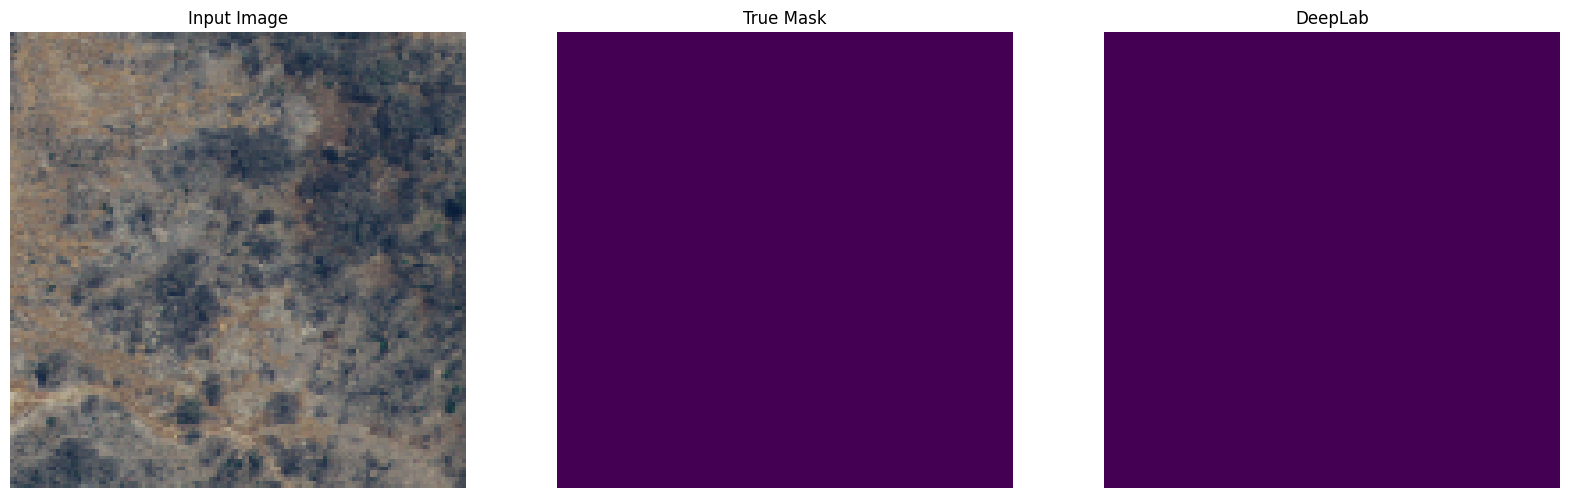

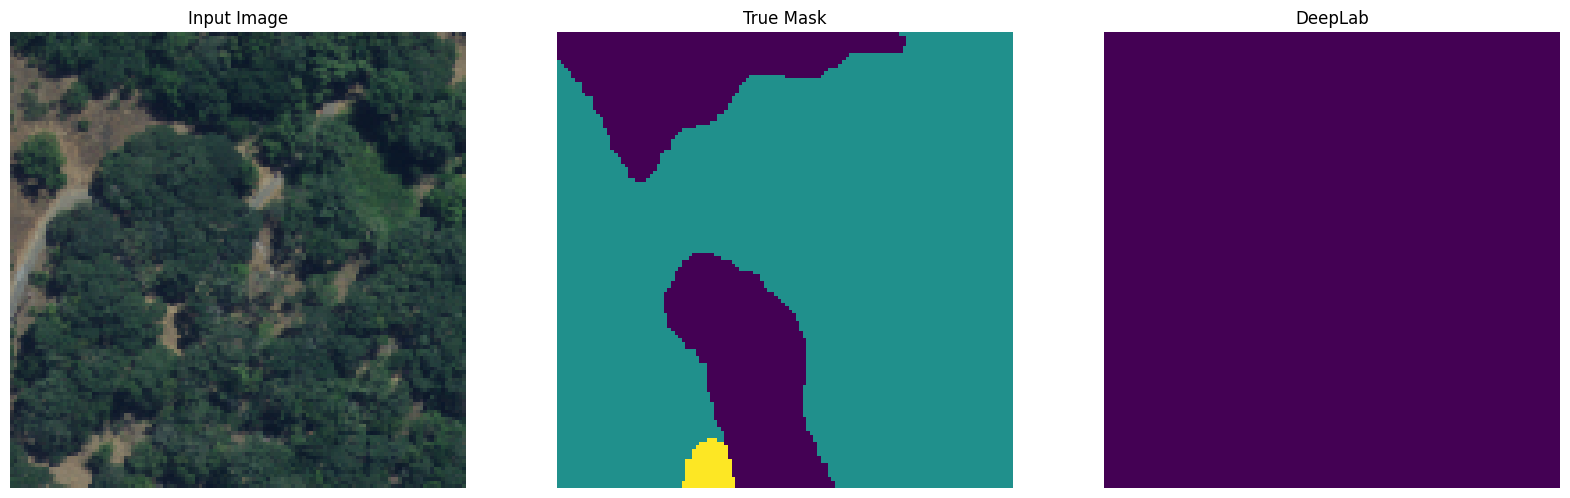

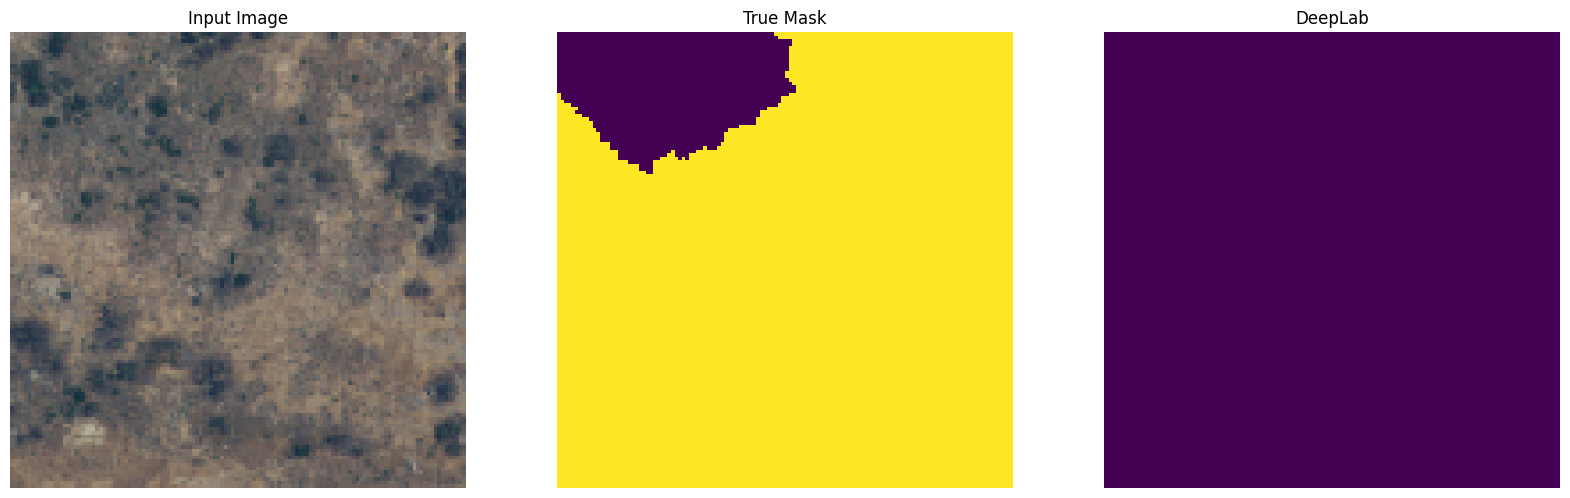

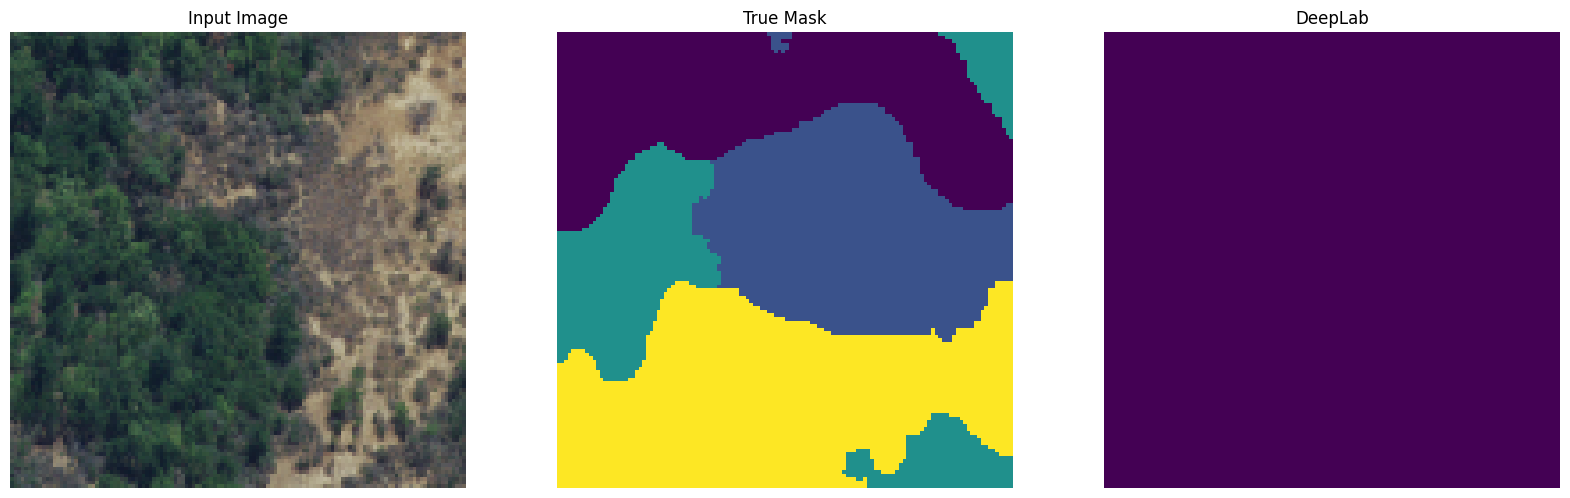

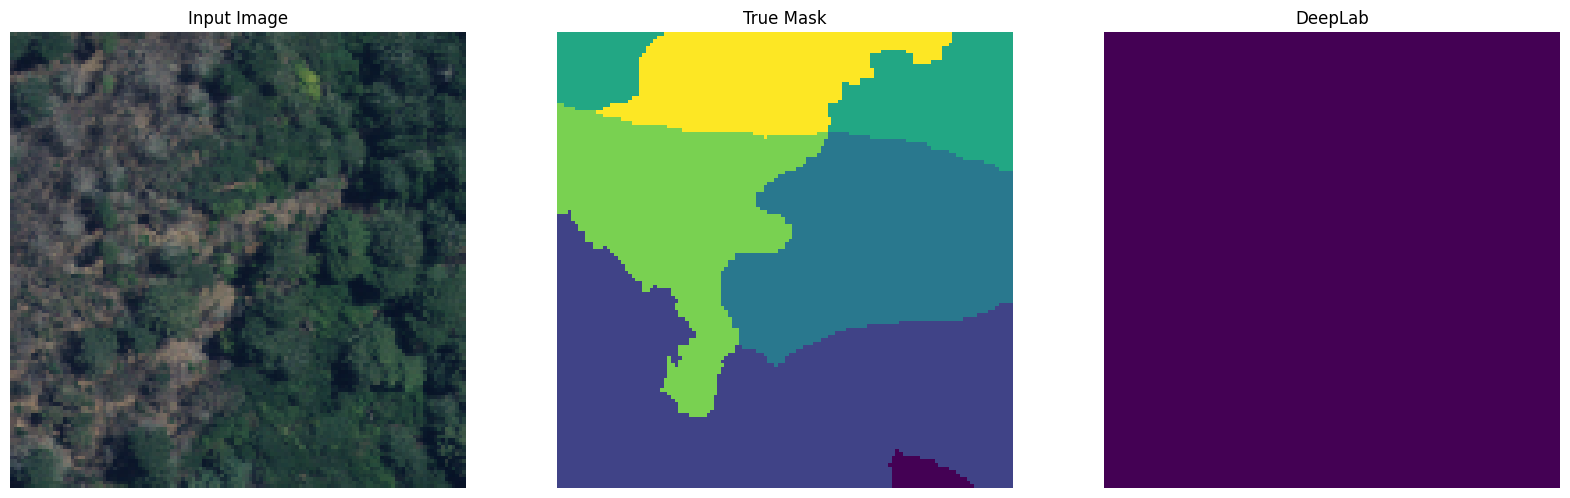

In [16]:
hp.show_predictions(model_deeplab, test_images[100:105], test_labels[100:105], 5, "DeepLab")

## Results Visualization ##
- In this Section we will be creating our final mask
- We will be using all three models we developed and feeding them into a soft voting algorithm
- In soft voting, each model in the ensemble assigns probabilities or confidence scores to each class label, and the final prediction is determined by taking a weighted average or sum of these probabilities across all models.
- Our soft voting system also performs morphology closing in order to clean up the final masks
- We will then visualize the performance of this system by generating the confusion matrix for each mask
- Note: The soft voting system takes care of any preprocessing each model requires as long a mobile, simple or deep are in the model names

In [5]:
## Feed in the models that correspond to the testing data of tubbs fire
gc.collect()
svote_mask_tubbs = hp.voting(['Models/deeplabv3_seg_model_full_6class_PocketNuns.tf',
                        'Models/mobilenet_seg_model_full_6class_PocketNuns.tf',
                        'Models/simple_seg_model_full_6class_PocketNuns.tf'],
                       Tubbs_images, Tubbs_labels, offset=25, num=5)

2023-05-24 11:01:25.685198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 11:01:26.470861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-24 11:01:26.471408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9362 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Models/deeplabv3_seg_model_full_6class_PocketNuns.tf


2023-05-24 11:01:36.546103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


Models/mobilenet_seg_model_full_6class_PocketNuns.tf
Models/simple_seg_model_full_6class_PocketNuns.tf
int64
s_votingcomplete: 100%
0.31797612


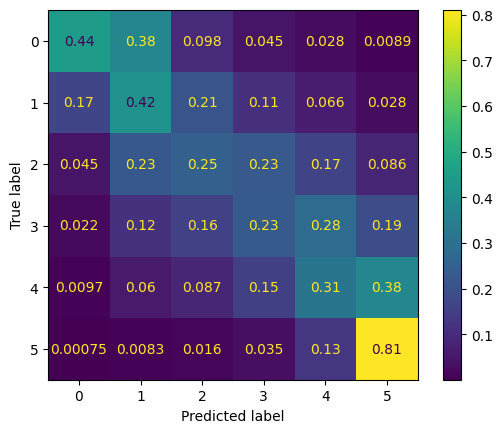

In [11]:
flat_preds = np.concatenate(svote_mask_tubbs).flatten()
flat_truth = np.concatenate(Tubbs_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [11]:
## Feed in the models that correspond to the testing data of pocket fire
gc.collect()
svote_mask_Pocket = hp.voting(['Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf',
                        'Models/mobilenet_seg_model_full_6class_NunsTubbs.tf',
                        'Models/simple_seg_model_full_6class_NunsTubbs.tf'],
                       Pocket_images, Pocket_labels, offset=25, num=5)

Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf
Models/mobilenet_seg_model_full_6class_NunsTubbs.tf
Models/simple_seg_model_full_6class_NunsTubbs.tf
int64
s_votingcomplete: 99%
0.05715829


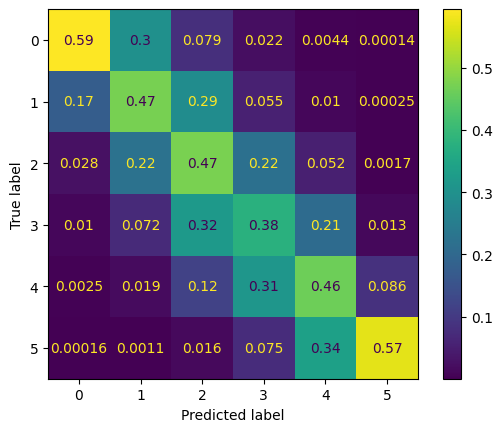

In [8]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Pocket).flatten()
flat_truth = np.concatenate(Pocket_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [21]:
## Feed in the models that correspond to the testing data of nuns fire
gc.collect()
svote_mask_Nuns = hp.voting(['Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf',
                        'Models/mobilenet_seg_model_full_6class_PocketTubbs.tf',
                         'Models/simple_seg_model_full_6class_PocketTubbs.tf'],
                       Nuns_images, Nuns_labels, offset=25, num=5)

Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf
Models/mobilenet_seg_model_full_6class_PocketTubbs.tf
Models/simple_seg_model_full_6class_PocketTubbs.tf


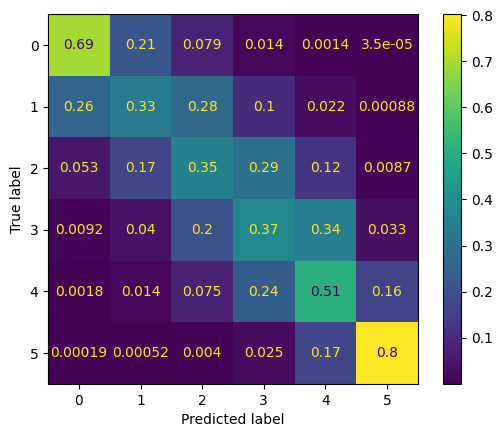

In [6]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Nuns).flatten()
flat_truth = np.concatenate(Nuns_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [12]:
## This section combines all the masks and labels to get a confusion matrix for each fire combined
final_labels = np.concatenate((Pocket_labels,Tubbs_labels,Nuns_labels), axis =0)
svote_mask_final = np.concatenate((svote_mask_Pocket,svote_mask_tubbs,svote_mask_Nuns), axis = 0)

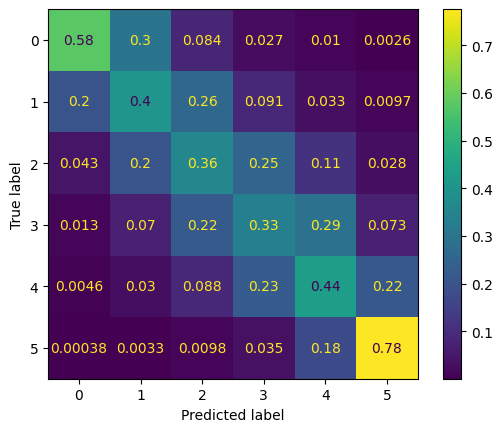

In [13]:
gc.collect()
flat_preds = np.concatenate(svote_mask_final).flatten()
flat_truth = np.concatenate(final_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

## Batching our Classes to improve results

- In this section we will be going over how to rebatch our classes in order to improve our results
- Batching is performed by combining classes that the model is predicting as similar into on class
- This can improve the performance of our model but sacrifices granularity in our class distribution
- Based on the confusion matrix from above we are batch our models as class 0 , [1,2] , [3,4], 5

In [15]:
## creating copies of our final mask generating from soft voting
svote_mask_final_bin = np.copy(svote_mask_final)
final_labels_bin = np.copy(final_labels)

In [16]:
## flating out these masks
flat_preds = np.concatenate(svote_mask_final_bin).flatten()
flat_truth = np.concatenate(final_labels_bin).flatten()

In [17]:
## checking that labels are correct
print(np.unique(flat_preds))
print(np.unique(flat_truth))

expected_labels = np.array([0, 1, 2, 3, 4, 5])
assert np.array_equal(np.unique(flat_preds), expected_labels)
assert np.array_equal(np.unique(flat_truth), expected_labels)

[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [18]:
## getting the indexes where different values occur in our predictions
preds0 = np.where(flat_preds==0)
preds12 = np.where((flat_preds==1) | (flat_preds==2))
preds34 = np.where((flat_preds==3) | (flat_preds==4))
preds5 = np.where(flat_preds==5)

In [19]:
## setting the value at those index to our desired values in our predicitions
flat_preds[preds0]=0
flat_preds[preds12]=1
flat_preds[preds34]=2
flat_preds[preds5]=3

In [20]:
## Doing the same thing for reference data
truth0 = np.where((flat_truth == 0))
truth12 = np.where((flat_truth == 1) | (flat_truth == 2))
truth34 = np.where((flat_truth == 3) | (flat_truth == 4))
truth5 = np.where((flat_truth == 5))
flat_truth[truth0]=0
flat_truth[truth12] = 1
flat_truth[truth34] = 2
flat_truth[truth5] = 3

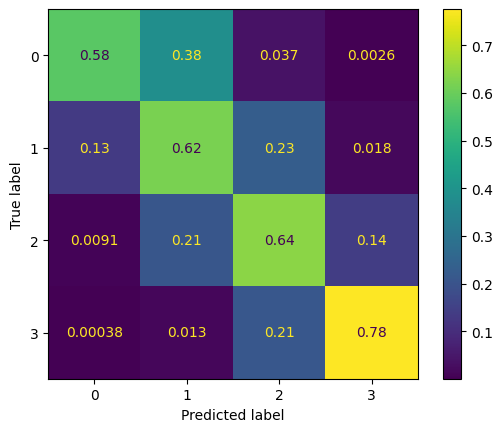

In [23]:
## Outputting the new confusion matrix for the batched models
gc.collect()
OUTPUT_CHANNELS = 4
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

## Generating our GeoReferenced prediction data
- In this section we will take our georeference data and combine it with our prediction masks
- This will output GEOtifs into a folder that we can later feed back into ARCgis
- In ARCgis these predictions can be displayed back onto the map
- This means we can visually compare our results to the reference data
- To do this we will be calling the function save_geo

- Note the folder names you choose need to already be created

In [ ]:
## This will save the predictions for the Nuns fire in folder called Nuns_predictions
hp.save_geo(svote_mask_Nuns.astype('uint8'),Nuns_geo,'Nuns_predictions')

In [10]:
## This will save the predictions for the Nuns fire in folder called Nuns_predictions
hp.save_geo(svote_mask_tubbs.astype('uint8'),Tubbs_geo,'Tubbs_predictions')

In [13]:
## This will save the predictions for the Nuns fire in folder called Nuns_predictions
hp.save_geo(svote_mask_Pocket.astype('uint8'),Pocket_geo,'Pocket_predictions')